# `pyroomacoustics` demo

In this IPython notebook, we demonstrate a few features of `pyroomacoustics`:

1. Its _pythonic_ and convenient object-oriented interface.
2. The Room Impulse Response (RIR) generator.
3. Provided reference algorithms. 

Below is a list of the examples (run all cells as some may depend on previous imports and results). 

1. [Creating a 2D/3D room](#room)
2. [Adding sources and microphones](#source_mic)
3. [Room Impulse Response generation and propagation simulation](#rir)
4. [Beamforming](#bf)
5. [Direction-of-arrival](#doa)
6. [Adaptive filtering](#af)
7. [STFT processing](#stft)
8. [Source Separation](#bss)

More information on the package can be found on the [Github repo](https://github.com/LCAV/pyroomacoustics) and from the [paper](https://arxiv.org/pdf/1710.04196.pdf), which can be cited as:

_R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018._

Let's begin by importing the necessary libraries all of which can be installed with `pip`, even `pyroomacoustics`!

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import scipy.signal as signal 

<a id='doa'></a>
## Direction of Arrival

Several reference algorithms for direction-of-arrival (DOA) estimation are provided. These methods work in the frequency domain of which there are generally two types: incoherent and coherent methods.

We provide the following algorithms: SRP-PHAT, MUSIC, CSSM, WAVES, TOPS, and FRIDA.

Let's perform DOA for two sources.

In [99]:
# Location of sources
azimuth = np.array([165.]) / 180. * np.pi
distance = 2.  # meters

A few constants and parameters for the algorithm such as the FFT size and the frequency range over which to perform DOA.

In [100]:
c = 343.    # speed of sound
fs = 96000  # sampling frequency
nfft = 256  # FFT size
freq_range = [30000, 50000]

Let's build a 2D room where we will perform our simulation.

(-1.0, 6.0)

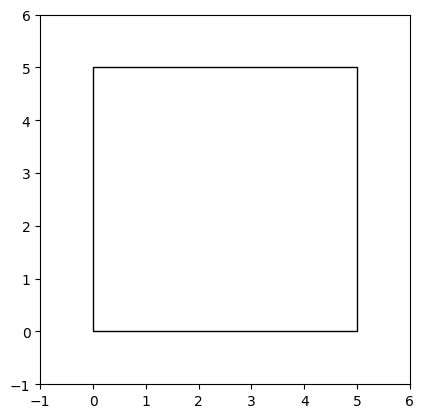

In [101]:
snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[5.,5.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

fig, ax = aroom.plot()
ax.set_xlim([-1, room_dim[0]+1])
ax.set_ylim([-1, room_dim[1]+1])

In [102]:
echo = pra.linear_2D_array(center=room_dim/2, M=5, phi=0, d=0.003)
echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)
aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

fig = plt.figure(figsize=(20, 8))
fig, ax = aroom.plot()

ax.set_xlim([-1, room_dim[0]+1]);
ax.set_ylim([-1, room_dim[1]+1]);

<Figure size 2000x800 with 0 Axes>

In [103]:
tone_durn = 2000e-3 # seconds
t_tone = np.linspace(0, tone_durn, int(fs*tone_durn))
chirp = signal.chirp(t_tone, 35e3, t_tone[-1], 45e3)
chirp *= signal.windows.hann(chirp.size)
output_chirp = np.concatenate((chirp, np.zeros((int(fs*0.2)))))

We'll create two synthetic signals and add them to the room at the specified locations with respect to the array.

In [104]:
# Add sources of 1 second duration
rng = np.random.RandomState(23)
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim/2  + distance * np.r_[np.cos(ang), np.sin(ang)]
    source_signal = output_chirp
    aroom.add_source(source_location, signal=source_signal)
    
# Run the simulation
aroom.simulate()

IPython.display.Audio(data=source_signal, rate=fs)

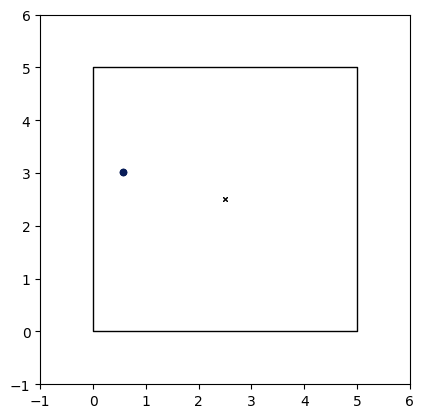

In [105]:
fig, ax = aroom.plot()

ax.set_xlim([-1, room_dim[0]+1]);
ax.set_ylim([-1, room_dim[1]+1]);

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [106]:
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

Now let's compare a few algorithms!

In [107]:
algo_names = ['SRP', 'MUSIC', 'FRIDA', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](echo, fs, nfft, c=c, num_src=2, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    if algo_name is 'FRIDA':
        spatial_resp[algo_name] = np.abs(doa._gen_dirty_img())
    else:
        spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

<>:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/pc/w8yjxfyn7g93139kxqngkny00000gn/T/ipykernel_6084/95203986.py:14: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if algo_name is 'FRIDA':
/Users/alberto/anaconda3/envs/Tesipython/lib/python3.12/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:1121: LinAlgWarning: Ill-conditioned matrix (rcond=2.02747e-19): result may not be accurate.
  linalg.solve(np.dot(Rc0, np.dot(GtG_inv_lst[loop], Rc0.T)), Tbeta_loop),
/Users/alberto/anaconda3/envs/Tesipython/lib/python3.12/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:1121: LinAlgWarning: Ill-conditioned matrix (rcond=1.12879e-19): result may not be accurate.
  linalg.solve(np.dot(Rc0, np.dot(GtG_inv_lst[loop], Rc0.T)), Tbeta_loop),
/Users/alberto/anaconda3/envs/Tesipython/lib/python3.12/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:1121: LinAlgWarning: Ill-co

Let's plot the estimated spatial spectra and compare it with the true locations!

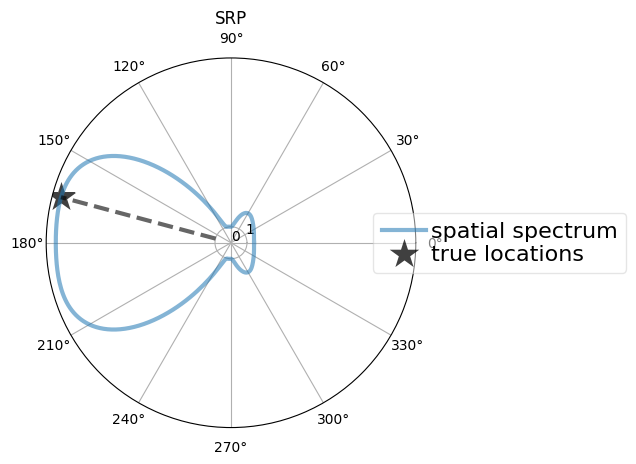

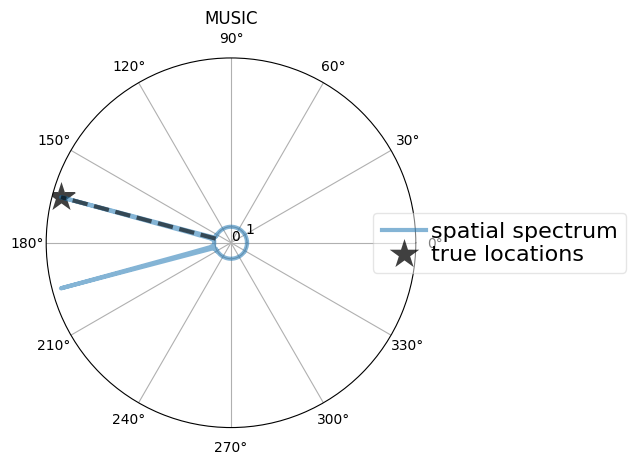

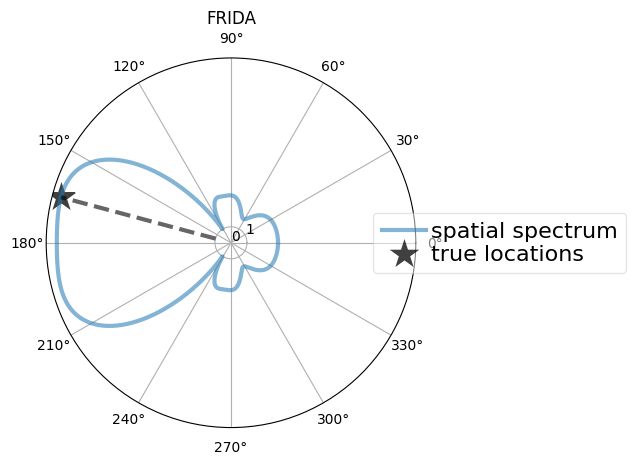

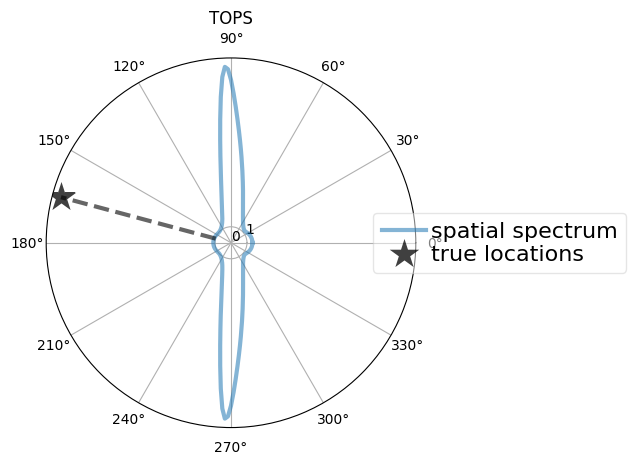

In [108]:
# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true locations')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    # ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
    # ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)])
    
plt.show()